In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2
from data_generation import create_data_set

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
plate1 = np.load('../../../../../../../datax/scratch/pma/real_filtered_HIP110750.npy')[15000:]
plate2 = np.load('../../../../../../../datax/scratch/pma/real_filtered_HIP13402.npy')[20000:]
plate3 = np.load('../../../../../../../datax/scratch/pma/real_filtered_HIP8497.npy')[20000:]
plate = np.vstack([plate1, plate2, plate3])
del plate1, plate2, plate3 
gc.collect()
print(plate.shape)

(32402, 6, 16, 2048)


In [3]:
%matplotlib inline
NUM_SAMPLES = 2
WIDTH_BIN=2048
data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1, WIDTH_BIN=WIDTH_BIN )

Creating True
(2, 6, 16, 2048)
(2, 6, 16, 2048) (2, 6, 16, 256)
(2, 6, 16, 256)
(12, 16, 256, 1)
Creating False
(12, 6, 16, 2048) (12, 6, 16, 256)
(12, 6, 16, 256)
Creating True
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(12, 6, 16, 256, 1)


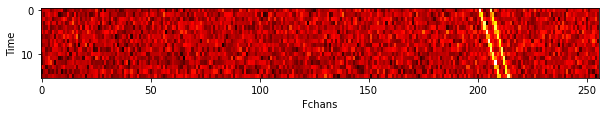

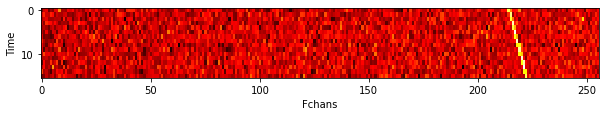

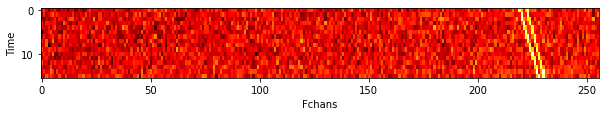

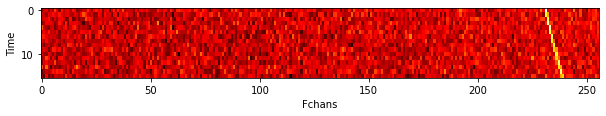

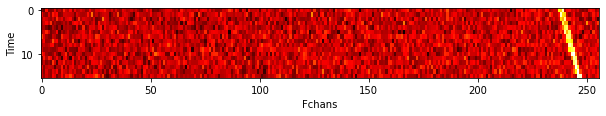

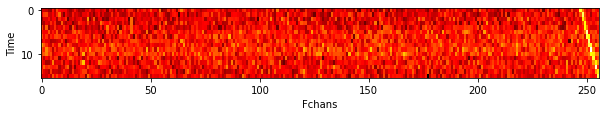

In [4]:
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[0,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

In [5]:
NUM_SAMPLES = 2
data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1, WIDTH_BIN=WIDTH_BIN)

Creating True
(2, 6, 16, 2048)
(2, 6, 16, 2048) (2, 6, 16, 256)
(2, 6, 16, 256)
(12, 16, 256, 1)
Creating False
(12, 6, 16, 2048) (12, 6, 16, 256)
(12, 6, 16, 256)
Creating True
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(6, 6, 16, 2048) (6, 6, 16, 256)
(6, 6, 16, 256)
(12, 6, 16, 256, 1)


In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha=10, beta=2, gamma = 10, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.true_score_tracker = keras.metrics.Mean(name="true_score")
        self.false_score_tracker = keras.metrics.Mean(name="false_score")
        
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        self.true_score_tracker_validation = keras.metrics.Mean(name="true_score")
        self.false_score_tracker_validation = keras.metrics.Mean(name="false_score")
        
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += (difference - same)/same
        else:
            similarity += (difference - same)/difference
 
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def false_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += -(difference - same)/same
        else:
            similarity += -(difference - same)/difference
        
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )/(16*256)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            
#             false_score = self.false_score(false_data)
#             true_score = self.true_score(true_data)
            false_score =0
            true_score = 0
            
            total_loss = reconstruction_loss/(16*256) + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        
        self.false_score_tracker.update_state(false_score)
        self.true_score_tracker.update_state(true_score)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result(),
            "false_score": self.false_score_tracker.result(),
            "true_score": self.true_score_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )/(16*256)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
#         false_score = self.false_score(false_data)
#         true_score = self.true_score(true_data)
        false_score = 0
        true_score =0
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        self.false_score_tracker_validation.update_state(false_score)
        self.true_score_tracker_validation.update_state(true_score)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result(),
            "false_score": self.false_score_tracker_validation.result(),
            "true_score": self.true_score_tracker_validation.result()
        }

In [7]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_model(latent_dim=8,dens_lay=512, kernel=(3,3), alpha=10, beta=2, gamma=10):
    
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=l1(0.001),
                          kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var" , activity_regularizer=l1(0.001),
                             kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001), 
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(latent_inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(1* 16 * 256, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Reshape((1,16, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder, alpha, beta, gamma)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

alpha, beta, gamma = 100,2,0
latent_dim=8
dens_lay=512
kernel=(3,3)


model_num = 55
name = "VAE-BLPC0-ENCODER_compressed_256v%d"%(model_num)
print(name)

print("Model " +name+": \(\\alpha : %3d\),  \(\\beta : %3d\),  \(\gamma : %3d\), latent_dim:%3d, dense:%3d " % (alpha, beta, gamma, latent_dim, dens_lay))

with strategy.scope():
    model = build_model(latent_dim,dens_lay, kernel, alpha, beta, gamma)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
VAE-BLPC0-ENCODER_compressed_256v55
Model VAE-BLPC0-ENCODER_compressed_256v55: \(\alpha : 100\),  \(\beta :   2\),  \(\gamma :   0\), latent_dim:  8, dense:512 
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 256, 1)] 0                                            
__________________________

tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

In [11]:
def plot_model(history, name, i):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))

    fig.suptitle("Model v%3d: alpha:%3d, beta:%3d, gamma:%3d, latent_dim:%3d, dense:%3d " % (model_num, alpha, beta, gamma, latent_dim, dens_lay))

    ax1.plot(history.history['false_loss'])
    ax1.plot(history.history['true_loss'])
    ax1.plot(history.history['val_false_loss'])
    ax1.plot(history.history['val_true_loss'])
    ax1.set_title('Model Clustering Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['false_loss', 'true_loss','val_false_loss','val_true_loss'], loc='upper right')
    ax1.grid()

    ax2.plot(history.history['false_score'])
    ax2.plot(history.history['true_score'])
    ax2.plot(history.history['val_false_score'])
    ax2.plot(history.history['val_true_score'])
    ax2.set_title('Model Clustering Score')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['false_score', 'true_score','val_false_score','val_true_score'], loc='upper right')
    ax2.grid()

    ax3.plot(history.history['reconstruction_loss'])
    ax3.plot(history.history['val_reconstruction_loss'])
    ax3.set_title('Model Reconstruction')
    ax3.set_ylabel('loss')
    ax3.set_xlabel('epoch')
    ax3.legend(['reconstruction_loss', 'val_reconstruction_loss'], loc='upper right')
    ax3.grid()

    ax4.plot(history.history['kl_loss'])
    ax4.plot(history.history['val_kl_loss'])
    ax4.set_title('Model Divergence')
    ax4.set_ylabel('loss')
    ax4.set_xlabel('epoch')
    ax4.legend(['kl_loss', 'val_kl_loss'], loc='upper right')
    ax4.grid()
    fig.savefig(name+"-"+str(i)+'.png')

0
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)
(60000, 6, 16, 256)
Creating True
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(60000, 6, 16, 256, 1)
Creating True
(1000, 6, 16, 2048)
(1000, 6, 16, 2048) (1000, 6, 16, 256)
(1000, 6, 16, 256)
(6000, 16, 256, 1)
Creating False
(6000, 6, 16, 2048) (6000, 6, 16, 256)
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)
4082.4746029376984
Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3'

30/30 [==============================] - 24s 819ms/step - loss: 2509.9358 - reconstruction_loss: 0.6533 - kl_loss: 19.1528 - false_loss: 11.5341 - true_loss: 17.8136 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2686.7593 - val_reconstruction_loss: 0.6577 - val_kl_loss: 15.2583 - val_false_loss: 9.4448 - val_true_loss: 17.1111 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 6/100
30/30 [==============================] - 22s 741ms/step - loss: 2417.6167 - reconstruction_loss: 0.6531 - kl_loss: 24.1241 - false_loss: 10.7395 - true_loss: 17.6114 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2637.1604 - val_reconstruction_loss: 0.6569 - val_kl_loss: 16.9516 - val_false_loss: 8.9951 - val_true_loss: 17.0309 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 7/100
30/30 [==============================] - 21s 695ms/step - loss: 2376.5709 - reconstruction_loss: 0.6530 - kl_loss: 28.3156 - false_loss: 10.1407 - true_loss: 17.4374 

Epoch 25/100
30/30 [==============================] - 20s 662ms/step - loss: 651.2883 - reconstruction_loss: 0.6527 - kl_loss: 48.0053 - false_loss: 4.8894 - true_loss: 9.4976 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1448.2397 - val_reconstruction_loss: 0.6537 - val_kl_loss: 37.3655 - val_false_loss: 4.4300 - val_true_loss: 9.2986 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 26/100
30/30 [==============================] - 20s 678ms/step - loss: 644.4572 - reconstruction_loss: 0.6528 - kl_loss: 47.6281 - false_loss: 4.7614 - true_loss: 9.2759 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1420.2644 - val_reconstruction_loss: 0.6537 - val_kl_loss: 37.7707 - val_false_loss: 4.3268 - val_true_loss: 9.1139 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 27/100
30/30 [==============================] - 22s 716ms/step - loss: 636.7649 - reconstruction_loss: 0.6527 - kl_loss: 47.9332 - false_loss: 4.6430 - true_loss: 9.0

Epoch 45/100
30/30 [==============================] - 20s 673ms/step - loss: 618.2159 - reconstruction_loss: 0.6523 - kl_loss: 47.9764 - false_loss: 3.3938 - true_loss: 6.9007 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1115.0455 - val_reconstruction_loss: 0.6531 - val_kl_loss: 42.1360 - val_false_loss: 3.2296 - val_true_loss: 7.0716 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 46/100
30/30 [==============================] - 20s 658ms/step - loss: 598.8900 - reconstruction_loss: 0.6522 - kl_loss: 48.4104 - false_loss: 3.3521 - true_loss: 6.8285 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1105.5044 - val_reconstruction_loss: 0.6531 - val_kl_loss: 42.2603 - val_false_loss: 3.1938 - val_true_loss: 7.0095 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 47/100
30/30 [==============================] - 20s 674ms/step - loss: 595.7322 - reconstruction_loss: 0.6520 - kl_loss: 48.9124 - false_loss: 3.3120 - true_loss: 6.7

Epoch 65/100
30/30 [==============================] - 21s 688ms/step - loss: 577.1292 - reconstruction_loss: 0.6517 - kl_loss: 48.9540 - false_loss: 2.7935 - true_loss: 5.8561 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 980.0702 - val_reconstruction_loss: 0.6526 - val_kl_loss: 44.2358 - val_false_loss: 2.7559 - val_true_loss: 6.1535 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 66/100
30/30 [==============================] - 20s 685ms/step - loss: 576.0837 - reconstruction_loss: 0.6517 - kl_loss: 48.9800 - false_loss: 2.7722 - true_loss: 5.8190 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 975.3199 - val_reconstruction_loss: 0.6526 - val_kl_loss: 44.3100 - val_false_loss: 2.7395 - val_true_loss: 6.1210 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 67/100
30/30 [==============================] - 20s 679ms/step - loss: 570.8133 - reconstruction_loss: 0.6516 - kl_loss: 49.2045 - false_loss: 2.7515 - true_loss: 5.782

Epoch 85/100
30/30 [==============================] - 20s 662ms/step - loss: 569.2898 - reconstruction_loss: 0.6526 - kl_loss: 48.6338 - false_loss: 2.4598 - true_loss: 5.2776 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 906.4092 - val_reconstruction_loss: 0.6524 - val_kl_loss: 45.3069 - val_false_loss: 2.4993 - val_true_loss: 5.6521 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 86/100
30/30 [==============================] - 20s 657ms/step - loss: 561.3455 - reconstruction_loss: 0.6525 - kl_loss: 49.4909 - false_loss: 2.4467 - true_loss: 5.2549 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 903.7537 - val_reconstruction_loss: 0.6524 - val_kl_loss: 45.3759 - val_false_loss: 2.4916 - val_true_loss: 5.6319 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 87/100
30/30 [==============================] - 20s 657ms/step - loss: 580.7484 - reconstruction_loss: 0.6522 - kl_loss: 49.0942 - false_loss: 2.4341 - true_loss: 5.233

30/30 [==============================] - 19s 619ms/step - loss: 579.5174 - reconstruction_loss: 0.6515 - kl_loss: 47.3703 - false_loss: 2.2638 - true_loss: 4.9391 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 863.1924 - val_reconstruction_loss: 0.6523 - val_kl_loss: 46.0167 - val_false_loss: 2.3516 - val_true_loss: 5.3534 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 19s 633ms/step - loss: 584.8983 - reconstruction_loss: 0.6521 - kl_loss: 47.3825 - false_loss: 2.2561 - true_loss: 4.9248 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 861.1194 - val_reconstruction_loss: 0.6524 - val_kl_loss: 46.0508 - val_false_loss: 2.3433 - val_true_loss: 5.3403 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 5/50
30/30 [==============================] - 19s 631ms/step - loss: 591.3746 - reconstruction_loss: 0.6519 - kl_loss: 47.2500 - false_loss: 2.2483 - true_loss: 4.9107 - false_score: 

Epoch 23/50
30/30 [==============================] - 20s 662ms/step - loss: 544.4036 - reconstruction_loss: 0.6518 - kl_loss: 47.8530 - false_loss: 2.1155 - true_loss: 4.6846 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 822.5198 - val_reconstruction_loss: 0.6526 - val_kl_loss: 46.3490 - val_false_loss: 2.1911 - val_true_loss: 5.1006 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 24/50
30/30 [==============================] - 20s 680ms/step - loss: 552.2963 - reconstruction_loss: 0.6515 - kl_loss: 47.5415 - false_loss: 2.1085 - true_loss: 4.6734 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 820.6315 - val_reconstruction_loss: 0.6526 - val_kl_loss: 46.3610 - val_false_loss: 2.1843 - val_true_loss: 5.0883 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 25/50
30/30 [==============================] - 20s 673ms/step - loss: 545.5592 - reconstruction_loss: 0.6519 - kl_loss: 47.6876 - false_loss: 2.1016 - true_loss: 4.6623 -

Epoch 43/50
30/30 [==============================] - 19s 652ms/step - loss: 521.2615 - reconstruction_loss: 0.6516 - kl_loss: 48.7522 - false_loss: 1.9804 - true_loss: 4.4781 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 787.2404 - val_reconstruction_loss: 0.6527 - val_kl_loss: 46.6337 - val_false_loss: 2.0624 - val_true_loss: 4.8708 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 44/50
30/30 [==============================] - 20s 653ms/step - loss: 512.8277 - reconstruction_loss: 0.6518 - kl_loss: 48.9164 - false_loss: 1.9741 - true_loss: 4.4687 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 785.6083 - val_reconstruction_loss: 0.6527 - val_kl_loss: 46.6494 - val_false_loss: 2.0566 - val_true_loss: 4.8599 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 45/50
30/30 [==============================] - 20s 659ms/step - loss: 508.4690 - reconstruction_loss: 0.6513 - kl_loss: 49.0792 - false_loss: 1.9675 - true_loss: 4.4592 -

30/30 [==============================] - 20s 675ms/step - loss: 513.5637 - reconstruction_loss: 0.6519 - kl_loss: 50.3542 - false_loss: 1.8746 - true_loss: 4.3337 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 759.8471 - val_reconstruction_loss: 0.6527 - val_kl_loss: 46.9786 - val_false_loss: 1.9598 - val_true_loss: 4.6925 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 12/25
30/30 [==============================] - 20s 668ms/step - loss: 508.7293 - reconstruction_loss: 0.6520 - kl_loss: 50.8007 - false_loss: 1.8689 - true_loss: 4.3265 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 758.3932 - val_reconstruction_loss: 0.6527 - val_kl_loss: 47.0028 - val_false_loss: 1.9539 - val_true_loss: 4.6834 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 13/25
30/30 [==============================] - 20s 680ms/step - loss: 504.6927 - reconstruction_loss: 0.6515 - kl_loss: 51.1061 - false_loss: 1.8632 - true_loss: 4.3192 - false_score

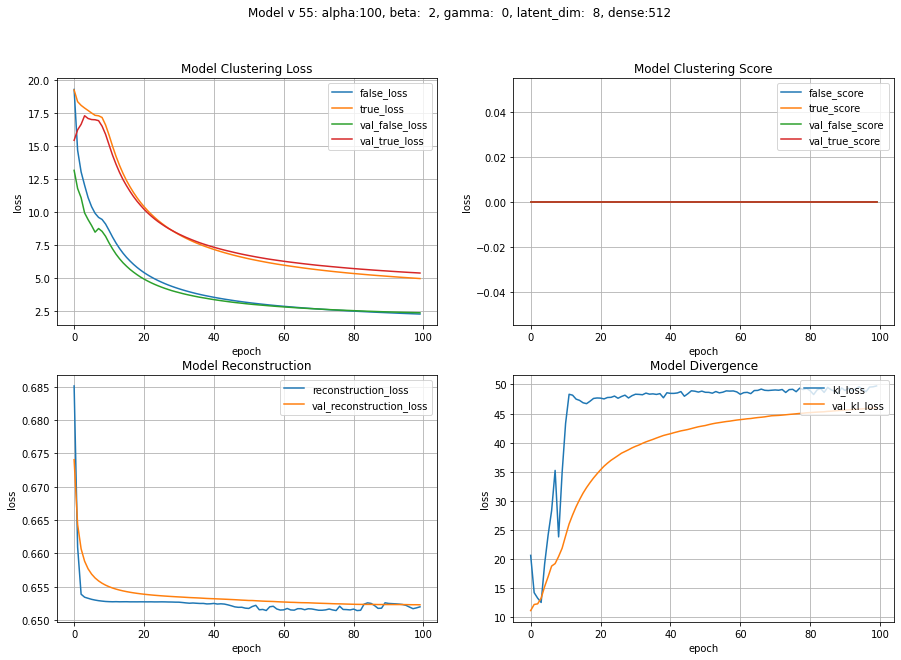

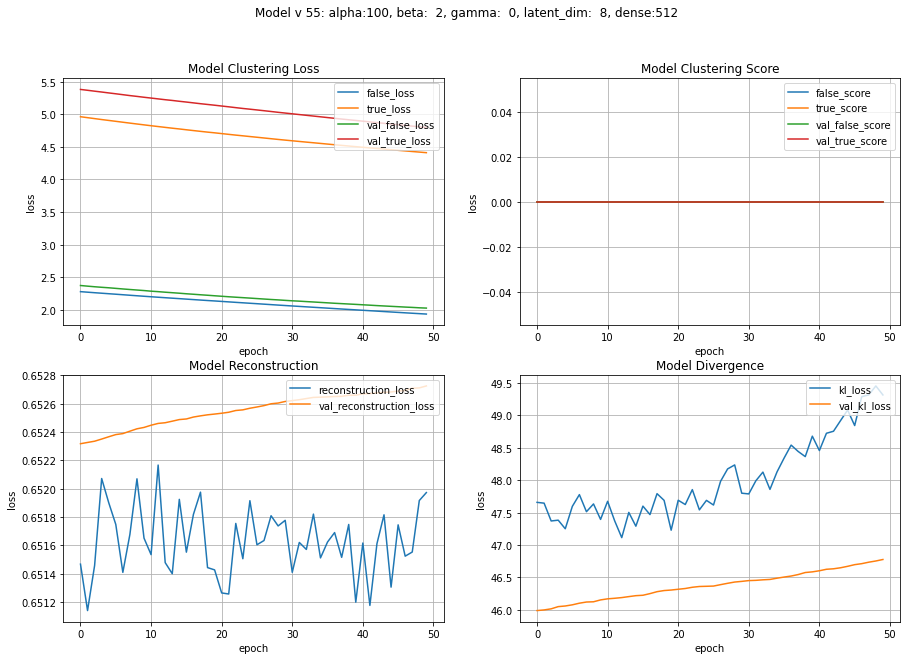

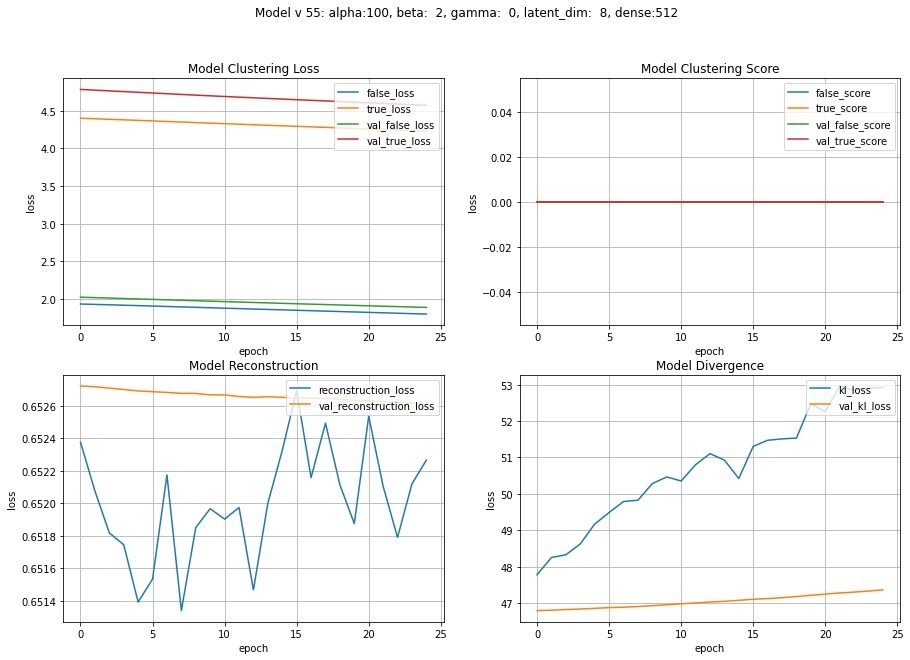

In [12]:
BATCH= 3
NUM_SAMPLES = 10000
epoch=[100,50,25, 100, 100,100,100,100, 100, 100]
snr_bases_list = [5,5,5,5,5,5,5,5,5,5]
for i in range(BATCH):
    print(i)
    start = time.time()
    data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=snr_bases_list[i], snr_range = 60, factor=1, WIDTH_BIN=WIDTH_BIN)
    data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=1000, snr_base=snr_bases_list[i], snr_range = 60, factor=1, WIDTH_BIN=WIDTH_BIN)
    print(time.time()-start)
    history = model.fit(x = [data, true_data, false_data], y= data[:,:,:,:], epochs=epoch[i], batch_size=2000, 
          validation_data=([data_test, true_data_test, false_data_test ], data_test),validation_batch_size=6000)
    
    del data, false_data, true_data
    gc.collect()
    model.encoder.save(name+"-"+str(i)+".h5")
    plot_model(history, name, i)

In [13]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))


NameError: name 'data' is not defined